In [1]:
import sys
sys.path.append("/home/sergey/tools/scLiTr/")
import sclitr as sl

import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import cospar

sc.set_figure_params(dpi=80)
sns.set_style("ticks")

sc.settings.figdir = "figures_DARLIN"
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

from scipy.sparse import csr_matrix

In [2]:
adata = sc.read_h5ad("data/tissue_adata_refined_20221106_joint.h5ad")

adata.layers["log1p"] = sc.pp.log1p(adata.X, copy=True)
adata.X = csr_matrix(np.round(
    (adata.X.A.T * (adata.obs.total_counts.values / 10000)).T
))

adata = adata[
    (adata.obs.tissue == "Skull") &
    (adata.obs.state_info != "Dc")
]

clone_obs = np.array(["NA"] * len(adata)).astype("object")
for cell, clone in np.argwhere(adata.obsm["X_clone"].A):
    clone_obs[cell] = f"clone_{clone}"
    
adata.obs["clone"] = clone_obs.copy()

/tmp/ipykernel_18374/628443191.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["clone"] = clone_obs.copy()


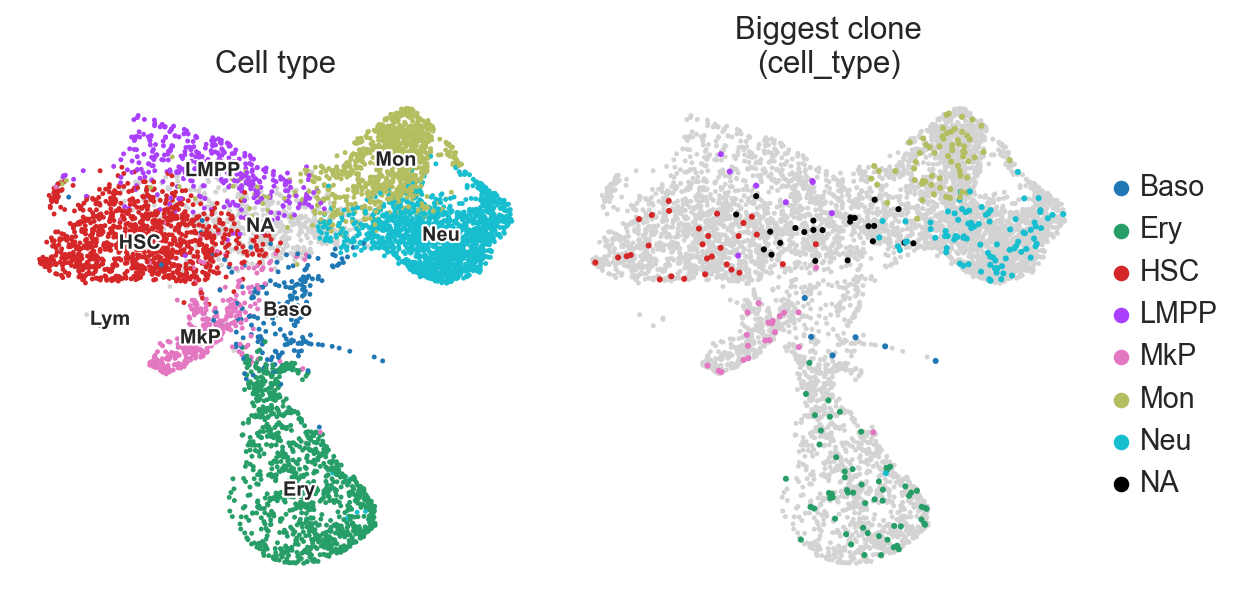

In [73]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

clone_col = "clone"

sc.pl.embedding(
    adata,
    basis="X_emb",
    color="cell_type",
    frameon=False,
    title="Cell type",
    legend_loc="on data",
    legend_fontsize=9,
    legend_fontoutline=2,
    ax=axes[0],
    show=False,
)

sl.pl.clone(
    adata,
    clone_col=clone_col,
    clone_name=adata.obs[clone_col].value_counts().index[1],
    basis="X_emb",
    title="Biggest clone",
    kwargs_clone={"color": "cell_type"},
    ax=axes[1],
)

fig.tight_layout()
plt.savefig("figures_DARLIN/embedding.pdf", bbox_inches="tight")

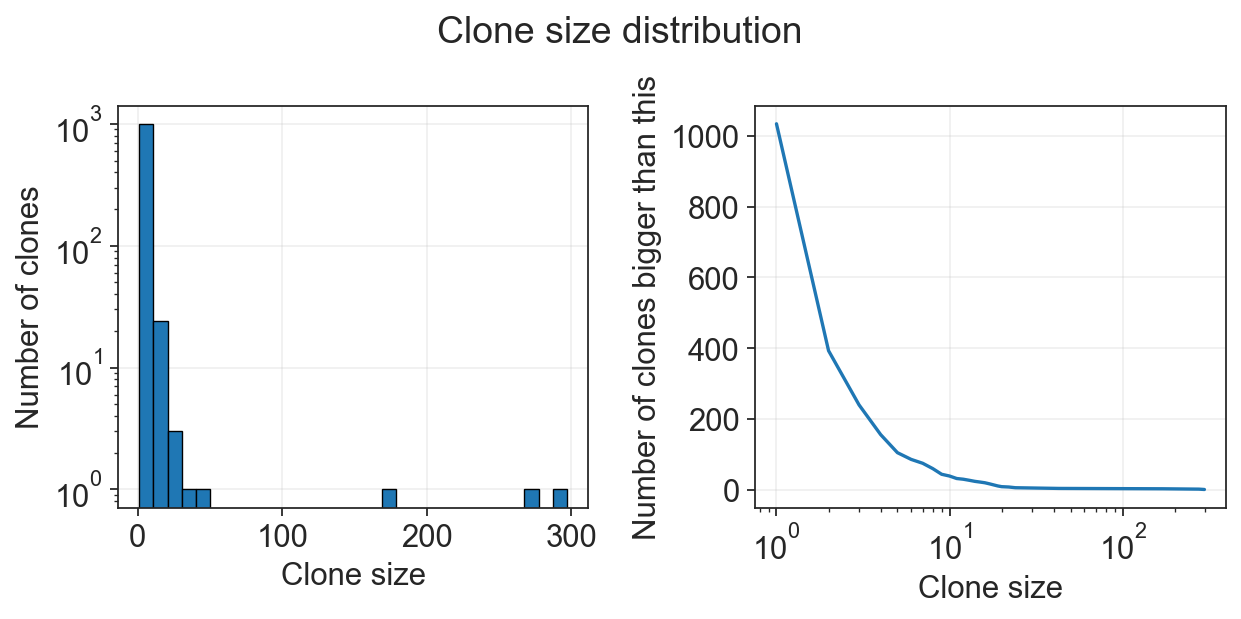

In [74]:
sl.pl.basic_stats(adata, obs_name=clone_col, title="Clone size distribution")

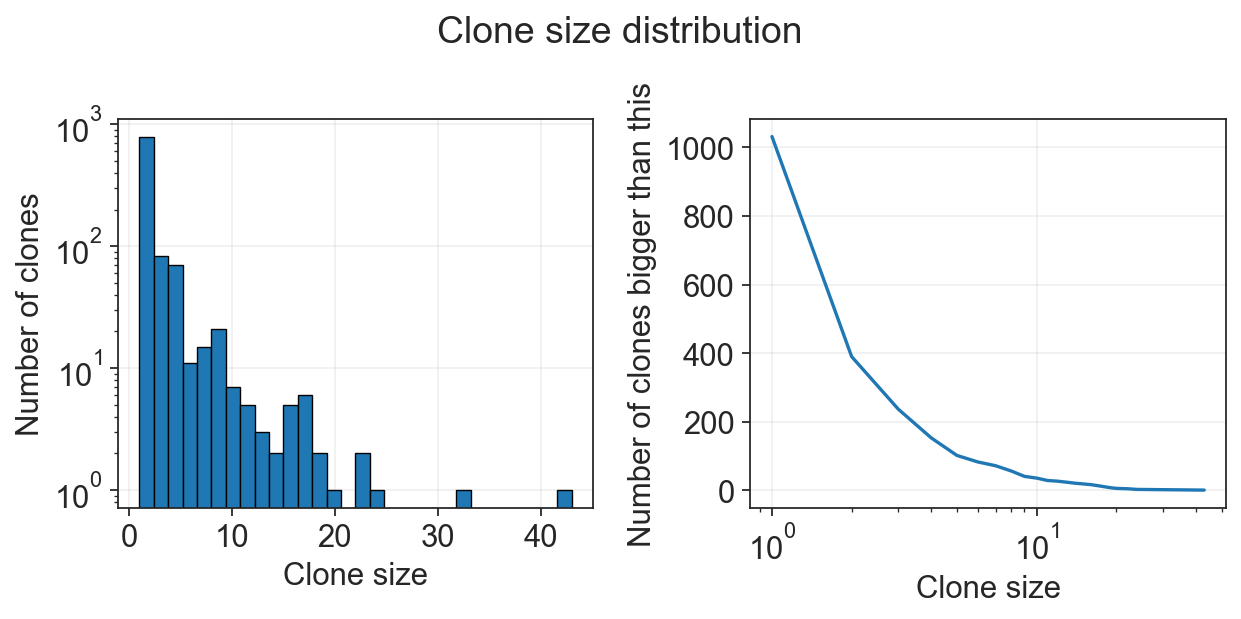

In [75]:
sl.pp.filter_clones(adata, clonal_obs=clone_col, inplace=True, max_size=100)
sl.pl.basic_stats(adata, obs_name=clone_col, title="Clone size distribution")
plt.savefig("figures_DARLIN/clone_size_proportions.pdf", bbox_inches="tight")

In [76]:
sl.tl.clonal_nn(
    adata,
    obs_name=clone_col,
    use_rep="X_pca",
    min_size=2,
    tqdm_bar=True,
    k=15,
)

100%|██████████| 6094/6094 [00:06<00:00, 1013.74it/s]


In [7]:
clones = sl.tl.clone2vec(
    adata,
    obs_name=clone_col,
    fill_ct="cell_type",
    device="cuda:0",
    n_epochs=150,
    z_dim=5,
)

# Filling NaNs — fix this bug later
clones.layers["frequencies"][np.isnan(clones.layers["frequencies"])] = 0

100%|██████████| 150/150 [01:50<00:00,  1.36it/s]
/home/sergey/tools/scLiTr/sclitr/tl.py:227: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_counts = adata_only_clones.obs.groupby(
/home/sergey/tools/scLiTr/sclitr/tl.py:235: RuntimeWarning: invalid value encountered in divide
  freqs = cell_counts / cell_counts.sum(axis=0)


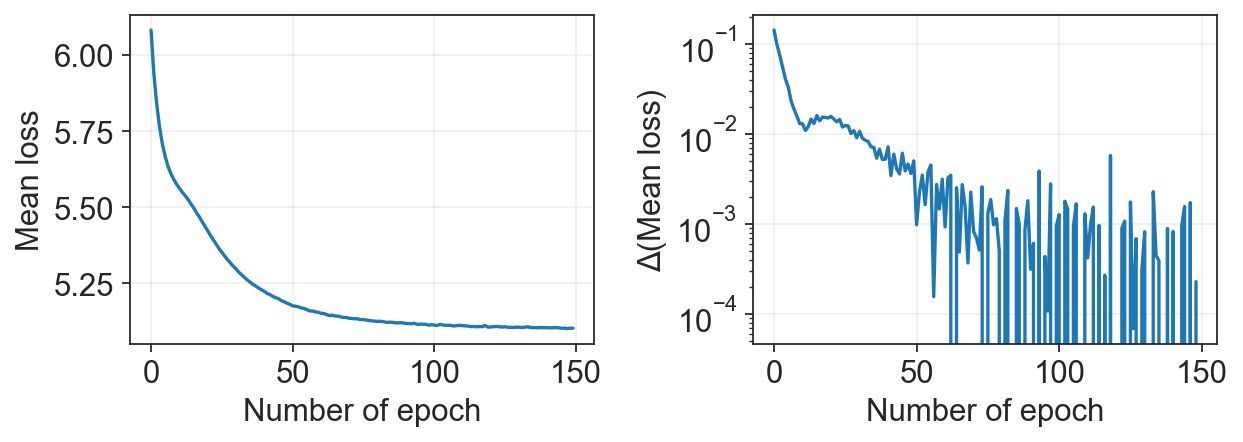

In [8]:
sl.pl.epochs_loss(clones)

In [9]:
sc.pp.neighbors(clones, use_rep="clone2vec")
sc.tl.umap(clones)

2025-04-01 12:43:47.120428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-01 12:43:47.209928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-01 12:43:47.234824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 12:43:47.389587: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-01 12:43:48.544489: W tensorflow/compiler/tf2

/tmp/ipykernel_15388/2054548961.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(clones, resolution=0.75)


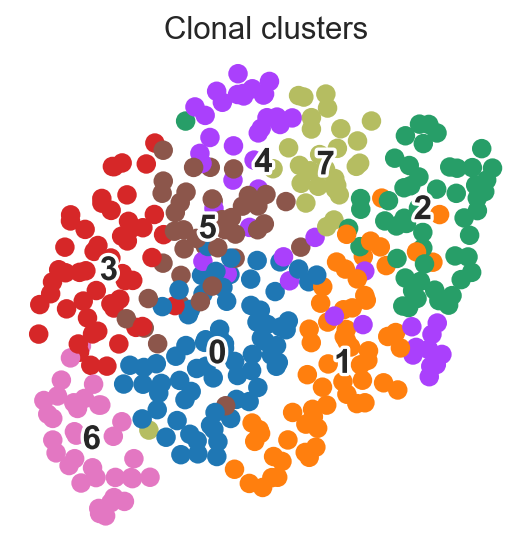

In [10]:
sc.tl.leiden(clones, resolution=0.75)

sc.pl.umap(
    clones,
    color="leiden",
    frameon=False,
    title="Clonal clusters",
    legend_loc="on data",
    legend_fontsize=15,
    legend_fontoutline=3,
    save="_clone2vec.pdf"
)

In [11]:
clones.write_h5ad("DARLIN_clones.h5ad")

In [191]:
clones.obs["MkP_imputed"] = np.array([
    clones[:, "MkP"].layers["frequencies"].T[0][
        np.argwhere(clones.obsp["distances"][i].A[0]).T[0]
    ].mean() for i in range(len(clones))
])

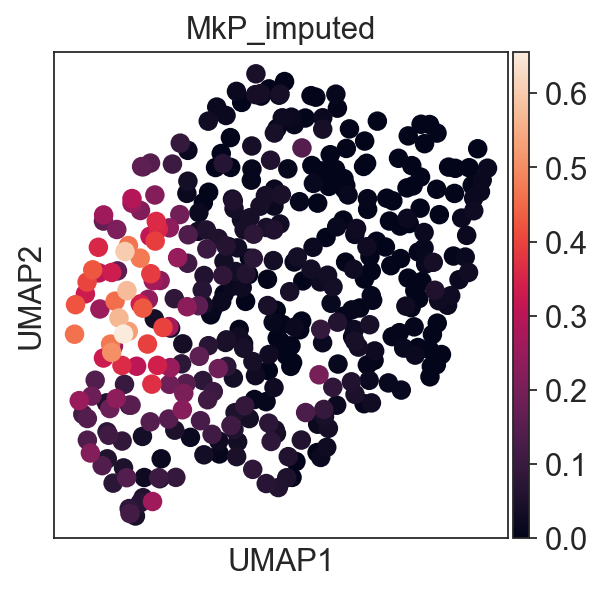

In [192]:
sc.pl.umap(
    clones,
    color=["MkP_imputed"],
    layer="frequencies",
)

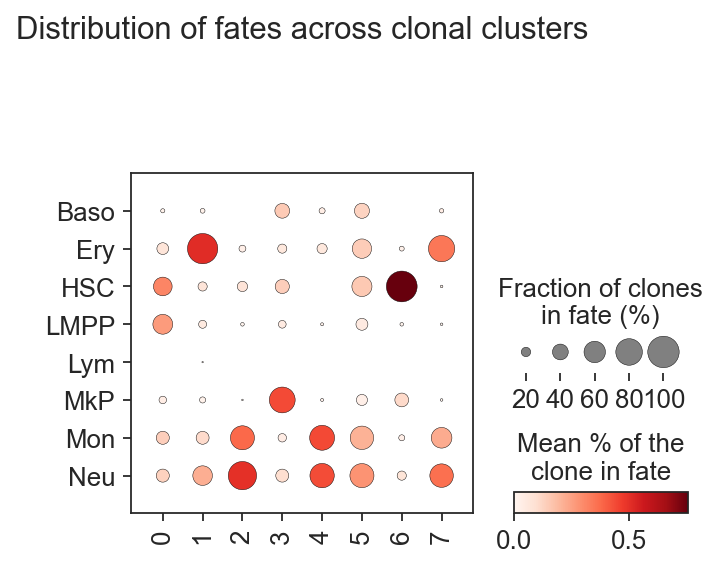

In [193]:
sc.pl.dotplot(
    clones,
    var_names=clones.var_names,
    groupby="leiden",
    layer="frequencies",
    colorbar_title="Mean % of the\nclone in fate",
    cmap="Reds",
    swap_axes=True,
    size_title="Fraction of clones\nin fate (%)",
    title="Distribution of fates across clonal clusters",
    dot_max=1,
    save="fate_distribution.pdf"
)

In [194]:
sl.tl.transfer_clonal_annotation(
    adata,
    clones,
    adata_clone_name=clone_col,
    adata_obs_name="Clonal cluster",
    clones_obs_name="leiden",
    fill_values="NA",
)

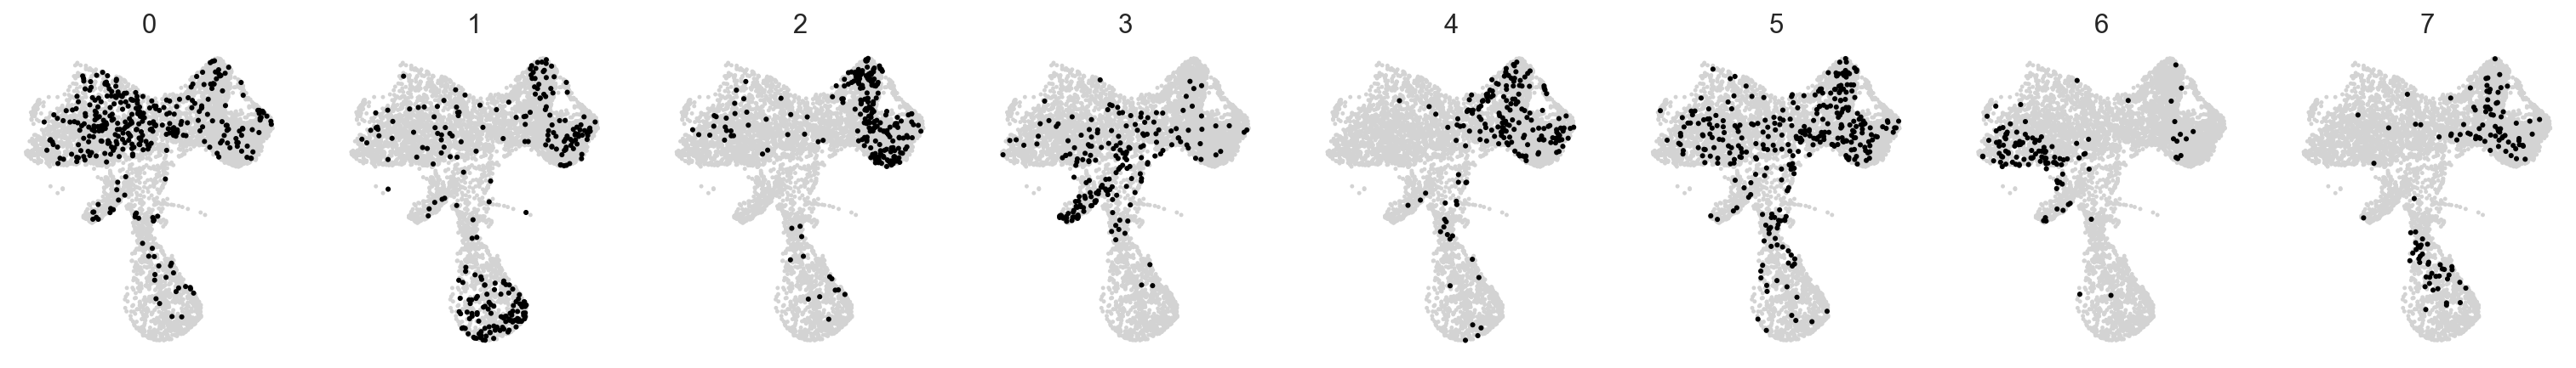

In [196]:
ncols = 8

fig, axes = plt.subplots(ncols=ncols, figsize=(3 * ncols, 3))

for i in range(ncols):
    sl.pl.clone(
        adata,
        clone_col="Clonal cluster",
        clone_name=str(i),
        ax=axes[i],
    )
    
plt.savefig("figures_DARLIN/clonal_clusters_projections.pdf", bbox_inches="tight")

In [197]:
# kNN classificator of cells outside clonal clusters

sl.tl.clonal_nn(adata, obs_name="Clonal cluster", k=10, use_rep="X_pca")
probs = adata.obsm["bag-of-clones"].A / adata.obsm["bag-of-clones"].sum(axis=1)

for i, cluster_name in enumerate(adata.uns["bag-of-clones_names"]):
    adata.obs[f"clonal_cluster_{cluster_name}_prob"] = probs[:, i].T.A[0]

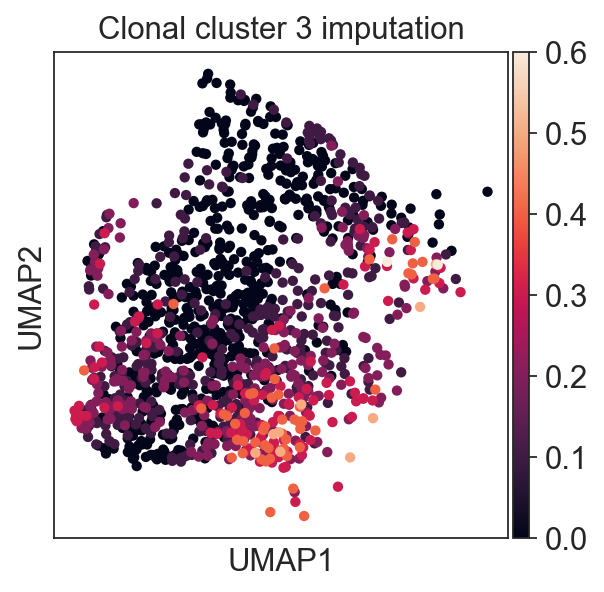

In [198]:
adata_prog = adata[adata.obs.cell_type.isin(["HSC", "LMPP"])].copy()
adata_prog.X = adata_prog.X.astype(int).A

sc.pl.umap(adata_prog, color="clonal_cluster_3_prob",
           title="Clonal cluster 3 imputation", save="imputation_results.pdf")

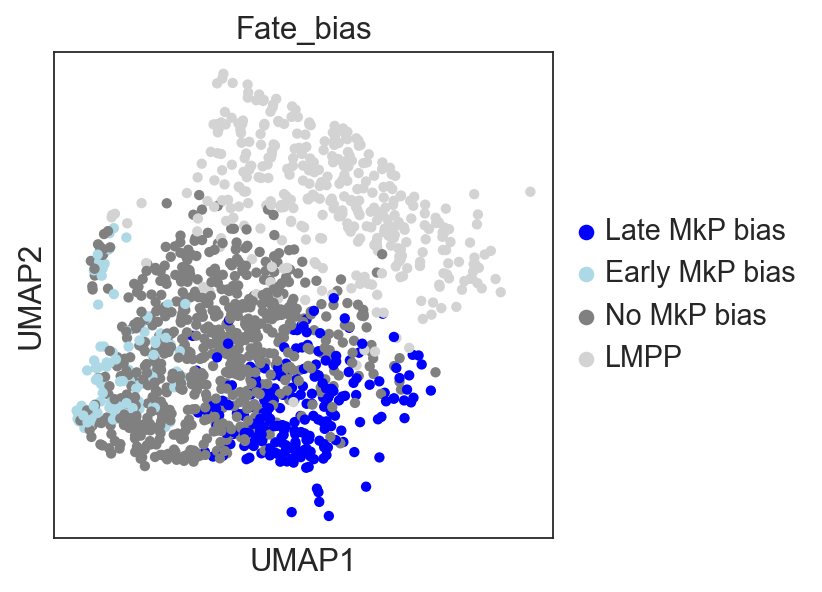

In [205]:
min_prob = 0.2

paper_like_annotation = np.array(["NA"] * len(adata_prog)).astype(object)
paper_like_annotation[adata_prog.obs.clonal_cluster_3_prob >= min_prob] = "Early MkP bias"
paper_like_annotation[
    (adata_prog.obs.clonal_cluster_3_prob >= min_prob) &
    (adata_prog.obsm["X_emb"][:, 0] >= 4)
] = "Late MkP bias"
paper_like_annotation[adata_prog.obs.clonal_cluster_3_prob < min_prob] = "No MkP bias"
paper_like_annotation[adata_prog.obs.cell_type == "LMPP"] = "LMPP"
adata_prog.obs["Fate_bias"] = paper_like_annotation.copy()
adata_prog.obs["Fate_bias"] = adata_prog.obs["Fate_bias"].astype("category").cat.reorder_categories([
    "Late MkP bias", "Early MkP bias", "No MkP bias", "LMPP", 
])

sc.pl.umap(adata_prog, color="Fate_bias", palette={
    "LMPP": "lightgrey",
    "No MkP bias": "grey",
    "Early MkP bias": "lightblue",
    "Late MkP bias": "blue",
}, save="_imputation_assignment.pdf")

In [258]:
# Differential expression
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=adata_prog,
    design="~Fate_bias",
    ref_level="Early MkP bias",
    refit_cooks=True,
    inference=inference,
)
dds.deseq2()
ds = DeseqStats(
    dds,
    contrast=["Fate_bias", "No MkP bias", "Early MkP bias"],
    inference=inference,
)
ds.summary()
DEGs = ds.results_df.copy()

/tmp/ipykernel_4859/3916602402.py:7: DeprecationWarning: ref_level is deprecated and no longer has any effect. It will beremoved in a future release.
  dds = DeseqDataSet(
Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 1.35 seconds.

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer

Log2 fold change & Wald test p-value: Fate_bias No MkP bias vs Early MkP bias
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            0.007014       -0.072760  5.667831 -0.012837  0.989758   
Rp1             0.000000             NaN       NaN       NaN       NaN   
Gm37323         0.000000             NaN       NaN       NaN       NaN   
Mrpl15          0.661414        0.701878  0.353600  1.984950  0.047150   
Lypla1          0.348809       -0.178078  0.468772 -0.379882  0.704033   
...                  ...             ...       ...       ...       ...   
AC087559.3      0.001459       -0.034085  5.668252 -0.006013  0.995202   
CR974586.4      0.000000             NaN       NaN       NaN       NaN   
4933409K07Rik   0.003618       -0.034085  5.668252 -0.006013  0.995202   
CAAA01147332.1  0.016707        0.017117  3.703546  0.004622  0.996312   
AC149090.1      1.447957       -0.169901  0.213529 -0.795681  0.426218   

                    padj  
Xkr4  

... done in 2.46 seconds.



In [207]:
sc.tl.rank_genes_groups(
    adata_prog,
    groupby="Fate_bias",
    method="t-test",
    reference="Early MkP bias",
    layer="log1p",
)

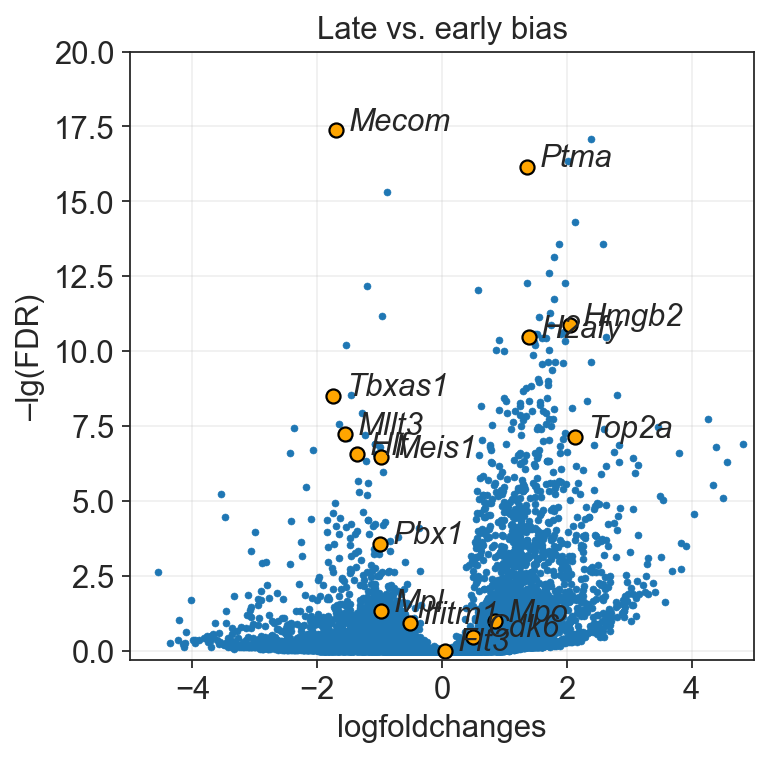

In [216]:
selected_genes = [
    "Hlf", "Mecom", "Mpl", "Mllt3",
    "Tbxas1", "Ifitm1", "Pbx1", "Meis1",
    "H2afy", "Ptma", "Cdk6", "Mpo", "Flt3",
    "Hmgb2", "Top2a",
]
df_DEG = sc.get.rank_genes_groups_df(adata_prog, group="Late MkP bias")
df_selected = df_DEG[df_DEG.names.isin(selected_genes)].copy()

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    x=df_DEG.logfoldchanges,
    y=-np.log10(df_DEG.pvals_adj),
    ax=ax,
    edgecolor=None,
    s=10,
)
sns.scatterplot(
    x=df_selected.logfoldchanges,
    y=-np.log10(df_selected.pvals_adj),
    ax=ax,
    edgecolor="black",
    linewidth=1,
    s=40,
    color="orange",
)
for i, gene in df_selected.iterrows():
    x = gene.logfoldchanges + 0.2
    y = -np.log10(gene.pvals_adj)
    if (x <= 20) and (x >= -20):
        ax.text(x=x, y=y, s=gene.names, style="italic")

ax.set_xlim(-5, 5)
ax.set_ylim(-0.3, 20)
ax.grid(alpha=0.3)

ax.set_ylabel("–lg(FDR)")

ax.set_title("Late vs. early bias")

plt.savefig("figures_DARLIN/late_vs_early.pdf", bbox_inches="tight")

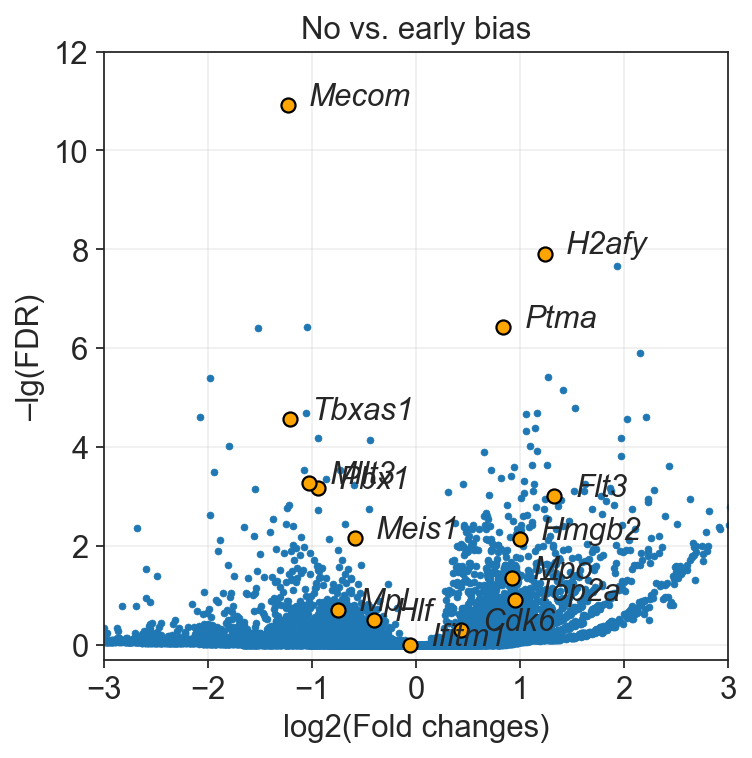

In [215]:
selected_genes = [
    "Hlf", "Mecom", "Mpl", "Mllt3",
    "Tbxas1", "Ifitm1", "Pbx1", "Meis1",
    "H2afy", "Ptma", "Cdk6", "Mpo", "Flt3",
    "Hmgb2", "Top2a",
]
df_DEG = sc.get.rank_genes_groups_df(adata_prog, group="No MkP bias")
df_selected = df_DEG[df_DEG.names.isin(selected_genes)].copy()

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    x=df_DEG.logfoldchanges,
    y=-np.log10(df_DEG.pvals_adj),
    ax=ax,
    edgecolor=None,
    s=10,
)
sns.scatterplot(
    x=df_selected.logfoldchanges,
    y=-np.log10(df_selected.pvals_adj),
    ax=ax,
    edgecolor="black",
    linewidth=1,
    s=40,
    color="orange",
)
for i, gene in df_selected.iterrows():
    x = gene.logfoldchanges + 0.2
    y = -np.log10(gene.pvals_adj)
    if (x <= 20) and (x >= -20):
        ax.text(x=x, y=y, s=gene.names, style="italic")

ax.set_xlim(-3, 3)
ax.set_ylim(-0.3, 12)
ax.grid(alpha=0.3)

ax.set_xlabel("log2(Fold changes)")
ax.set_ylabel("–lg(FDR)")

ax.set_title("No vs. early bias")
plt.savefig("figures_DARLIN/no_vs_early.pdf", bbox_inches="tight")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


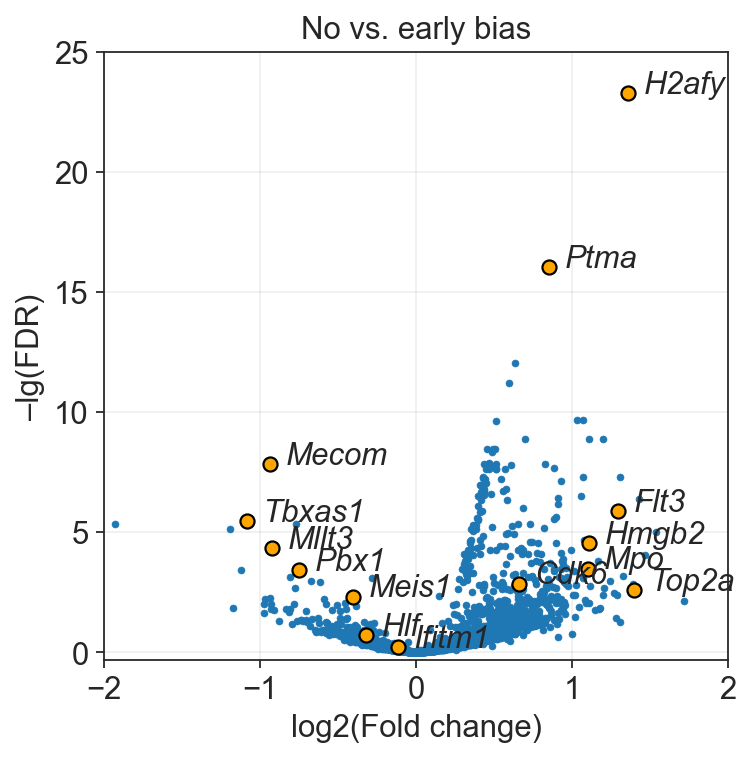

In [259]:
selected_genes = [
    "Hlf", "Mecom", "Mpl", "Mllt3",
    "Tbxas1", "Ifitm1", "Pbx1", "Meis1",
    "H2afy", "Ptma", "Cdk6", "Mpo", "Flt3",
    "Hmgb2", "Top2a",
]

df_DEG = DEGs.copy()
df_selected = DEGs.loc[selected_genes].copy()

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    x=df_DEG.log2FoldChange,
    y=-np.log10(df_DEG.padj),
    ax=ax,
    edgecolor=None,
    s=10,
)
sns.scatterplot(
    x=df_selected.log2FoldChange,
    y=-np.log10(df_selected.padj),
    ax=ax,
    edgecolor="black",
    linewidth=1,
    s=40,
    color="orange",
)
for i, gene in df_selected.iterrows():
    x = gene.log2FoldChange + 0.1
    y = -np.log10(gene.padj)
    if (x <= 20) and (x >= -20):
        ax.text(x=x, y=y, s=i, style="italic")

ax.set_xlim(-2, 2)
ax.set_ylim(-0.3, 25)
ax.grid(alpha=0.3)

ax.set_xlabel("log2(Fold change)")
ax.set_ylabel("–lg(FDR)")

ax.set_title("No vs. early bias")
plt.savefig("figures_DARLIN/no_vs_early_DESeq2.pdf", bbox_inches="tight")

In [240]:
adata_clones = adata[adata.obs["Clonal cluster"] != "NA"].copy()
adata_clones_HSC = adata_clones[adata_clones.obs.cell_type == "HSC"].copy()
adata_clones_HSC.X = adata_clones_HSC.X.A.astype(int)

adata_clones_HSC.obs["Progenitor_bias"] = [
    "True" if i == "6" else "False"
    for i in adata_clones_HSC.obs["Clonal cluster"]
]

In [248]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=adata_clones_HSC,
    design="~Progenitor_bias",
    ref_level="False",
    refit_cooks=True,
    inference=inference,
)
dds.deseq2()
ds = DeseqStats(
    dds,
    contrast=["Progenitor_bias", "True", "False"],
    inference=inference,
)
ds.summary()
DEGs = ds.results_df.copy()

/tmp/ipykernel_4859/2923640919.py:2: DeprecationWarning: ref_level is deprecated and no longer has any effect. It will beremoved in a future release.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.19 seconds.



Using None as control genes, passed at DeseqDataSet initialization


/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8

Log2 fold change & Wald test p-value: Progenitor_bias True vs False
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            0.005116        0.066737  3.222125  0.020712  0.983475   
Rp1             0.000000             NaN       NaN       NaN       NaN   
Gm37323         0.000000             NaN       NaN       NaN       NaN   
Mrpl15          0.574060        0.079911  0.410512  0.194662  0.845657   
Lypla1          0.385495        0.273576  0.598519  0.457088  0.647608   
...                  ...             ...       ...       ...       ...   
AC087559.3      0.006265        0.066737  3.222125  0.020712  0.983475   
CR974586.4      0.000000             NaN       NaN       NaN       NaN   
4933409K07Rik   0.000000             NaN       NaN       NaN       NaN   
CAAA01147332.1  0.000000             NaN       NaN       NaN       NaN   
AC149090.1      1.370516       -0.070597  0.309197 -0.228323  0.819395   

                    padj  
Xkr4            

... done in 1.88 seconds.



In [256]:
DEGs.dropna().sort_values("stat").tail(7)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Samd12,2.912484,0.687293,0.254460,2.700991,0.006913,0.999835
mt-Nd3,1.646136,0.739791,0.271011,2.729746,0.006338,0.999835
Epb41,1.333644,0.850187,0.308883,2.752455,0.005915,0.999835
Dlg2,1.392818,1.086712,0.360726,3.012566,0.002590,0.999835
Ifitm3,6.394112,0.430166,0.131215,3.278320,0.001044,0.887875
Cited2,1.119827,1.074329,0.326928,3.286135,0.001016,0.887875
mt-Cytb,20.825749,0.309606,0.093260,3.319821,0.000901,0.887875


In [334]:
def split_test_eval(
    clones: sc.AnnData,
    use_rep: str = "clone2vec",
    fraction: float = 0.2,
    add_label: str | None = "eval_set",
) -> (list, list):
    from geosketch import gs

    idx = gs(
        X=clones.obsm[use_rep],
        N=np.round(len(clones) * fraction).astype(int),
    )
    validation = clones[idx].obs_names.copy()
    train = clones.obs_names[
        ~clones.obs_names.isin(validation)
    ].copy()

    if add_label:
        clones.obs[add_label] = [
            "validation" if i in validation else "train"
            for i in clones.obs_names
        ]
        clones.obs[add_label] = clones.obs[add_label].astype("category")
        
    return list(train), list(validation)

In [335]:
def run_CatBoostRegressor(
    train_expr: pd.DataFrame,
    train_c2v: pd.DataFrame,
    validation_expr: pd.DataFrame,
    validation_c2v: pd.DataFrame,
    use_gpu: bool = False,
    num_trees: int = 10000,
    early_stopping_rounds: int = 100,
    verbose: bool = True,
):
    from catboost import Pool, CatBoostRegressor
    
    if "celltype_column" in train_expr.columns:
        train = Pool(
            data=train_expr,
            label=train_c2v,
            cat_features=["celltype_column"],
        )
        validation = Pool(
            data=validation_expr,
            label=validation_c2v,
            cat_features=["celltype_column"],
        )
    else:
        train = Pool(data=train_expr, label=train_c2v)
        validation = Pool(data=validation_expr, label=validation_c2v)
        
    if use_gpu:
        task_type = "GPU"
    else:
        task_type = "CPU"
        
    model = CatBoostRegressor(
        loss_function="MultiRMSE",
        eval_metric="MultiRMSE",
        num_trees=num_trees,
        early_stopping_rounds=early_stopping_rounds,
        task_type=task_type,
        boosting_type="Plain",
        verbose=verbose,
    )
    
    model.fit(train, eval_set=validation, use_best_model=True)
    
    return model

In [383]:
def run_CatBoostClassifier(
    train_expr: pd.DataFrame,
    train_ct: pd.DataFrame,
    validation_expr: pd.DataFrame,
    validation_ct: pd.DataFrame,
    use_gpu: bool = False,
    num_trees: int = 10000,
    early_stopping_rounds: int = 100,
    verbose: bool = True,
):
    from catboost import Pool, CatBoostRegressor
    
    if "celltype_column" in train_expr.columns:
        train = Pool(
            data=train_expr,
            label=train_ct,
            cat_features=["celltype_column"],
        )
        validation = Pool(
            data=validation_expr,
            label=validation_ct,
            cat_features=["celltype_column"],
        )
    else:
        train = Pool(data=train_expr, label=train_ct)
        validation = Pool(data=validation_expr, label=validation_ct)
        
    if use_gpu:
        task_type = "GPU"
    else:
        task_type = "CPU"
        
    model = CatBoostClassifier(
        loss_function="MultiCrossEntropy",
        eval_metric="MultiCrossEntropy",
        num_trees=num_trees,
        early_stopping_rounds=early_stopping_rounds,
        task_type=task_type,
        verbose=verbose,
    )
    
    model.fit(train, eval_set=validation, use_best_model=True)
    
    return model

In [363]:
def prepare_expr(
    adata: sc.AnnData,
    clone_col: str = "clone",
    use_raw: bool = False,
    layer: str | None = None,
    ct_col: str | None = None,
) -> pd.DataFrame:
    
    if use_raw and layer:
        raise Exception("Only one of `use_raw` or `layer` should be used!")
    
    if use_raw:
        expr = adata.raw.to_adata().to_df()
    elif layer:
        expr = adata.layers[layer].A if "sparse" in str(type(adata.layers[layer])) else adata.layers[layer]
        expr = pd.DataFrame(expr, index=adata.obs_names, columns=adata.var_names)
    else:
        expr = adata.to_df()
    
    expr["clone_column"] = adata.obs[clone_col].astype(str)
    if ct_col:
        expr["celltype_column"] = adata.obs[ct_col]
    
    return expr

In [373]:
def prepare_pseudobulk(
    expr: pd.DataFrame,
    pseudobulk: bool = True,
    ct_col: str | None = None,
    limit_ct: str | None = None,
    use_ct: bool = False
) -> pd.DataFrame:
    if pseudobulk:
        if ct_col is None:
            expr = expr.groupby("clone_column").mean()
        else:
            expr = expr.groupby(["celltype_column", "clone_column"]).mean().reset_index().dropna()
            expr.index = expr.celltype_column.astype(str) + ":" + expr.clone_column.astype(str)
    
    if isinstance(limit_ct, str):
        expr = expr[expr.celltype_column == limit_ct]
    elif isinstance(limit_ct, list):
        expr = expr[expr.celltype_column.isin(limit_ct)]
    
    if not use_ct and ct_col:
        del expr["celltype_column"]
    
    return expr

In [409]:
def predict_c2v(
    adata: sc.AnnData,
    clones: sc.AnnData,
    use_rep: str = "clone2vec",
    predicted_rep: str = "clone2vec_predicted",
    add_label: str = "eval_set",
    eval_fraction: float = 0.2,
    clone_col: str = "clone",
    na_label: str = "NA",
    use_gpu: bool = False,
    use_raw: bool = False,
    layer: str | None = None,
    ct_col: str | None = None,
    pseudobulk: bool = True,
    limit_ct: str | None = None,
    use_ct: bool = True,
    num_trees: int = 10000,
    early_stopping_rounds: int = 100,
    filename: str = "model_c2v.cbm",
    use_model: str | None = None,
    verbose: bool = True,
) -> sc.AnnData:
    
    expr = prepare_expr(adata, clone_col, use_raw, layer, ct_col)
    expr = prepare_pseudobulk(expr, pseudobulk, ct_col, limit_ct, use_ct)
        
    if not use_model:
        if add_label in clones.obs.columns:
            train = list(clones.obs_names[clones.obs[add_label] == "train"])
            validation = list(clones.obs_names[clones.obs[add_label] == "validation"])
        else:
            # Train-validation split with Geosketch
            train, validation = split_test_eval(
                clones,
                use_rep=use_rep,
                fraction=eval_fraction,
                add_label=add_label,
            )

        train_expr = expr[expr.clone_column.isin(train)].copy()
        validation_expr = expr[expr.clone_column.isin(validation)].copy()

        train_c2v = clones[train_expr.clone_column].obsm[use_rep].copy()
        validation_c2v = clones[validation_expr.clone_column].obsm[use_rep].copy()

        del train_expr["clone_column"], validation_expr["clone_column"]

        # Running CatBoost
        model = run_CatBoostRegressor(
            train_expr, train_c2v, validation_expr,
            validation_c2v, use_gpu, num_trees,
            early_stopping_rounds, verbose,
        )
        model.save_model(filename)
    else:
        # Loading the model from the disk
        from catboost import CatBoostRegressor
        
        model = CatBoostRegressor()
        model.load(use_model)
    
    # Predicting the embedding
    from catboost import Pool
    
    expr_predict = expr[
        expr.clone_column.isin(train + validation)
    ].copy()
    clone_column_pred = expr_predict["clone_column"].values.copy()
    del expr_predict["clone_column"]
    
    if use_ct and ct_col:
        expr_pool = Pool(data=expr_predict, cat_features=["celltype_column"])
    else:
        expr_pool = Pool(data=expr_predict)
    c2v_predicted = model.predict(expr_pool)
    
    if sum(~clones.obs_names.isin(clone_column_pred)) != 0:
        print("Some of the clones doesn't contain cell type of interest. Putting the result of prediction in the uns.")
        clones_obs_names = clones.obs_names[
            clones.obs_names.isin(clone_column_pred)
        ].copy()
        uns = True
    else:
        clones_obs_names = clones.obs_names.copy()
        uns = False
        
    prediction = (
        pd.DataFrame(c2v_predicted)
        .groupby(clone_column_pred)
        .mean()
        .loc[clones_obs_names]
        .values
    )
    
    if uns:
        clones.uns[predicted_rep] = prediction.copy()
        clones.uns[predicted_rep + "_names"] = clone_column_pred.copy()
    else:
        clones.obsm[predicted_rep] = prediction.copy()
        
    # Extracting shapley values
    raw_shap = model.get_feature_importance(expr_pool, type="ShapValues")
    
    shapdata = sc.AnnData(
        X=np.linalg.norm(raw_shap, axis=1)[:, :-1],
        obs=pd.DataFrame(index=expr_predict.index),
        var=pd.DataFrame(index=expr_predict.columns),
    )
    
    for i in range(raw_shap.shape[1]):
        shapdata.layers[f"shap_c2v{i}"] = raw_shap[:, i, :-1]
    
    if use_ct:
        shapdata.obs[ct_col] = expr_predict.celltype_column
        
    shapdata.var["mean_shap"] = shapdata.X.mean(axis=0)
    shapdata.var["var_shap"] = np.var(shapdata.X, axis=0)
    
    return shapdata

In [410]:
shapdata_c2v = predict_c2v(
    adata,
    clones,
    clone_col="clone",
    ct_col="cell_type",
    use_gpu=True,
    verbose=False,
    limit_ct="HSC",
    use_ct=False,
    pseudobulk=False,
    layer="log1p",
)

Some of the clones doesn't contain cell type of interest. Putting the result of prediction in the uns.


In [411]:
shapdata_c2v.var.sort_values("mean_shap").tail(10)

,mean_shap,var_shap
Rpl30,0.028282,0.000052
Itpk1,0.028793,0.000858
Flt3,0.032916,0.000127
Cdk6,0.034553,0.000164
Slco3a1,0.043244,0.000488
Rnf220,0.051082,0.000206
Mpo,0.060703,0.000407
Pcdh7,0.095925,0.000838
Tespa1,0.104267,0.003395
H2afy,0.201737,0.003527


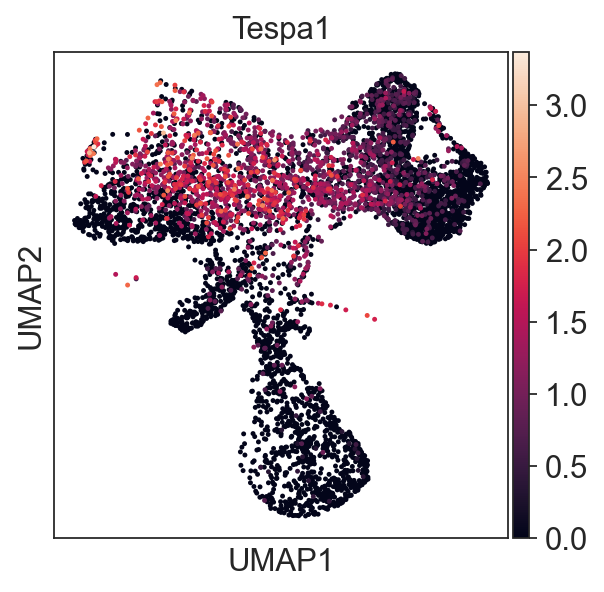

In [392]:
sc.pl.umap(adata, color="Tespa1", layer="log1p")

In [439]:
def predict_ct(
    adata: sc.AnnData,
    clones: sc.AnnData,
    use_rep: str = "clone2vec",
    predicted_rep: str = "ct_predicted",
    add_label: str = "eval_set",
    eval_fraction: float = 0.2,
    clone_col: str = "clone",
    na_label: str = "NA",
    use_gpu: bool = False,
    use_raw: bool = False,
    layer: str | None = None,
    ct_col: str | None = None,
    pseudobulk: bool = True,
    limit_ct: str | None = None,
    use_ct: bool = True,
    num_trees: int = 10000,
    early_stopping_rounds: int = 100,
    filename: str = "model_ct.cbm",
    use_model: str | None = None,
    verbose: bool = True,
    ct_layer: str | None = None,
) -> sc.AnnData:
    
    expr = prepare_expr(adata, clone_col, use_raw, layer, ct_col)
    expr = prepare_pseudobulk(expr, pseudobulk, ct_col, limit_ct, use_ct)
        
    if not use_model:
        if add_label in clones.obs.columns:
            train = list(clones.obs_names[clones.obs[add_label] == "train"])
            validation = list(clones.obs_names[clones.obs[add_label] == "validation"])
        else:
            # Train-validation split with Geosketch
            train, validation = split_test_eval(
                clones,
                use_rep=use_rep,
                fraction=eval_fraction,
                add_label=add_label,
            )

        train_expr = expr[expr.clone_column.isin(train)].copy()
        validation_expr = expr[expr.clone_column.isin(validation)].copy()
        
        if ct_layer:
            train_ct = clones[train_expr.clone_column].layers[ct_layer].copy()
            validation_ct = clones[validation_expr.clone_column].layers[ct_layer].copy()
        else:
            train_ct = clones[train_expr.clone_column].X.copy()
            validation_ct = clones[validation_expr.clone_column].X.copy()

        del train_expr["clone_column"], validation_expr["clone_column"]

        # Running CatBoost
        model = run_CatBoostRegressor(
            train_expr, train_ct, validation_expr,
            validation_ct, use_gpu, num_trees,
            early_stopping_rounds, verbose,
        )
        model.save_model(filename)
    else:
        # Loading the model from the disk
        from catboost import CatBoostRegressor
        
        model = CatBoostRegressor()
        model.load(use_model)
    
    # Predicting the embedding
    from catboost import Pool
    
    expr_predict = expr[
        expr.clone_column.isin(train + validation)
    ].copy()
    clone_column_pred = expr_predict["clone_column"].values.copy()
    del expr_predict["clone_column"]
    
    if use_ct and ct_col:
        expr_pool = Pool(data=expr_predict, cat_features=["celltype_column"])
    else:
        expr_pool = Pool(data=expr_predict)
    ct_predicted = model.predict(expr_pool)
    
    if sum(~clones.obs_names.isin(clone_column_pred)) != 0:
        print("Some of the clones doesn't contain cell type of interest. Putting the result of prediction in the uns.")
        clones_obs_names = clones.obs_names[
            clones.obs_names.isin(clone_column_pred)
        ].copy()
        uns = True
    else:
        clones_obs_names = clones.obs_names.copy()
        uns = False
        
    prediction = (
        pd.DataFrame(ct_predicted)
        .groupby(clone_column_pred)
        .mean()
        .loc[clones_obs_names]
        .values
    )
    
    if uns:
        clones.uns[predicted_rep] = prediction.copy()
        clones.uns[predicted_rep + "_names"] = clone_column_pred.copy()
    else:
        clones.obsm[predicted_rep] = prediction.copy()
        
    # Extracting shapley values
    raw_shap = model.get_feature_importance(expr_pool, type="ShapValues")
    
    shapdata = sc.AnnData(
        X=np.linalg.norm(raw_shap, axis=1)[:, :-1],
        obs=pd.DataFrame(index=expr_predict.index),
        var=pd.DataFrame(index=expr_predict.columns),
    )
    
    if use_ct:
        shapdata.obs[ct_col] = expr_predict.celltype_column
        del expr_predict["celltype_column"]
        
    Z_scores = sc.pp.scale(expr_predict.values, copy=True, max_value=10)
    non_ct_columns = expr_predict.columns != "celltype_column"
    
    for i, ct in enumerate(clones.var_names):
        shapdata.layers[f"shap_{ct}"] = raw_shap[:, i, :-1]
        shapdata.layers[f"shap_{ct}"][:, non_ct_columns] = (
            shapdata.layers[f"shap_{ct}"][:, non_ct_columns] *
            Z_scores
        )
        
    shapdata.var["mean_shap"] = shapdata.X.mean(axis=0)
    shapdata.var["var_shap"] = np.var(shapdata.X, axis=0)
    
    return shapdata

In [440]:
shapdata_ct = predict_ct(
    adata,
    clones,
    clone_col="clone",
    ct_col="cell_type",
    use_gpu=True,
    verbose=False,
    limit_ct="HSC",
    use_ct=False,
    pseudobulk=False,
    layer="log1p",
    ct_layer="frequencies",
)

Some of the clones doesn't contain cell type of interest. Putting the result of prediction in the uns.


In [464]:
np.sort(shapdata_ct.layers["shap_Neu"].mean(axis=0))

array([-0.00019049, -0.00013402, -0.00010436, ...,  0.00014053,
        0.00057586,  0.0005854 ])

In [460]:
pd.DataFrame(
    {"shap": shapdata_ct.layers["shap_Neu"].mean(axis=0)},
    index=shapdata_ct.var_names,
).sort_values("shap")

,shap
Ap2s1,-0.000190
Timm23,-0.000134
Cd27,-0.000104
Xkr4,0.000000
Tbcd,0.000000
...,...
Pcbp1,0.000000
Gm44036,0.000000
Sfi1,0.000141
Nono,0.000576


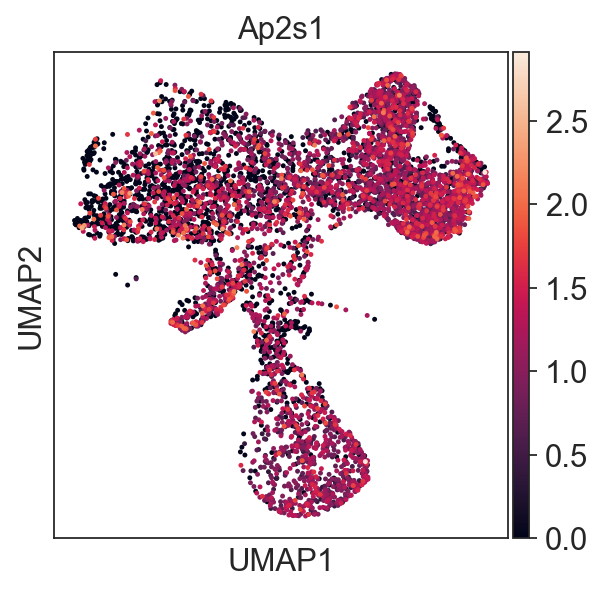

In [457]:
sc.pl.umap(adata, color="Ap2s1", layer="log1p")